<a href="https://colab.research.google.com/github/componavt/sns4human/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22gensim_model_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyldavis
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models
import gzip
import requests
from io import BytesIO
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary

# Получение токенизированных постов

In [ ]:
filename = 'state_tokens.csv.gz'
response = requests.get(f'https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/data/vk/posts/tokens/{filename}')
with gzip.GzipFile(fileobj=BytesIO(response.content), mode='rb') as f:
    tokens = pd.read_csv(f, delimiter=',', encoding='utf-8')['tokens']

data = tokens.apply(lambda x: x.split(' ')).tolist()


# Создание мешка слов
Преобразуем документы в векторизованную форму.
Мешок слов (BoW) — это  модель представления текста в виде числового вектора, где:

*    Учитывается наличие слов, но игнорируется их порядок (отсюда "мешок" — слова "перемешаны").

*   Каждому слову ставится в соответствие число (частота или бинарный флаг).




In [ ]:
dictionary = corpora.Dictionary(data)
corpus = [dictionary.doc2bow(text) for text in data]

num_topics = 8

# Тематическое моделирование

In [ ]:
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

topics = [[(term, round(wt, 3))
               for term, wt in lda_model.show_topic(n)]
                   for n in range(0, lda_model.num_topics)]
topics_df = pd.DataFrame([[term for term, wt in topic]
                              for topic in topics],
                         index=['Тема '+str(t) for t in range(1, lda_model.num_topics+1)]).T
topics_df

,Тема 1,Тема 2,Тема 3,Тема 4,Тема 5,Тема 6,Тема 7,Тема 8
0,карелия,карелия,район,коренной,карелия,больница,школа,район
1,республика,карельский,карелия,предприятие,семья,медицинский,детский,сутки
2,национальный,республика,республика,карелия,память,центр,здание,посёлок
3,подробный,культура,рубль,производство,победа,строительство,проект,коронавирус
4,организация,желать,житель,развитие,великий,ремонт,петрозаводск,ситуация
5,проект,язык,бюджет,завод,ребёнок,помощь,спортивный,число
6,карельский,праздник,млн,компания,житель,республиканский,сад,находиться
7,язык,поздравлять,развитие,продукция,акция,оборудование,программа,карелия
8,конкурс,народный,программа,карельский,петрозаводск,карелия,посёлок,республика
9,общественный,коллектив,проект,хозяйство,отечественный,врач,ремонт,петрозаводск


# Оценка

Измерение тематических моделей с помощью связности.
Если тема представляет собой смесь определенных слов, то один из способов измерения семантической связности темы — вычислить совместную встречаемость между словами. То есть, как часто верхние слова в теме встречаются вместе в документах по сравнению с тем, как часто они встречаются независимо.

Оценка тематической модели — сложная тема без четкого количественного подхода, и она до сих пор обсуждается. Более высокая (или более низкая оценка в зависимости от меры) не обязательно означает более высокую качественную модель. То есть оценку, которую человек дал бы, глядя на тематические слова и насколько они интерпретируемы.

# Анализ текущих параметров модели

**Perplexity** — это часто используемая метрика для оценки моделей LDA. Она измеряет, насколько хорошо модель предсказывает новые данные. Более низкий показатель perplexity указывает на лучшую производительность. Вы можете рассчитать perplexity с помощью метода log_perplexity() модели LDA в gensim.

**Интерпретация:**

Низкая перплексия → модель хорошо предсказывает данные.

Высокая перплексия → модель плохо обобщает.

In [ ]:
lda_model.log_perplexity(corpus)    # Чем ближе к 0, тем лучше

-7.9755666732657104

In [ ]:
# Вычислить оценку согласованности
coherence_model_lda = CoherenceModel(model=lda_model, texts=data,
                                     dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score:', coherence_lda)

Coherence Score: 0.580558482119647


# Попробуем повысить оценку

Мы удаляем редкие слова и общие слова на основе их частоты в документах . Ниже мы удаляем слова, которые встречаются менее чем в 20 документах или более чем в 50% документов. Попробуйте удалить слова только на основе их частоты или, может быть, объединить это с этим подходом.

Обрезка низко- и высокочастотных слов.

Одна из вещей, которую мы можем попробовать, — это отфильтровать редкие и распространенные токены.

In [ ]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(data)

# Отфильтровать слова, которые встречаются менее чем в 20 документах или более чем в 40% документов.
dictionary.filter_extremes(no_below=20, no_above=0.4)
corpus = [dictionary.doc2bow(doc) for doc in data]

lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

topics = [[(term, round(wt, 3))
               for term, wt in lda_model.show_topic(n)]
                   for n in range(0, lda_model.num_topics)]
topics_df = pd.DataFrame([[term for term, wt in topic]
                              for topic in topics],
                         index=['Тема '+str(t) for t in range(1, lda_model.num_topics+1)]).T
topics_df

,Тема 1,Тема 2,Тема 3,Тема 4,Тема 5,Тема 6,Тема 7,Тема 8
0,район,желать,праздник,национальный,предприятие,школа,сутки,проект
1,посёлок,поздравлять,акция,карельский,поддержка,коренной,ситуация,рубль
2,олонецкий,развитие,петрозаводск,язык,производство,ребёнок,число,строительство
3,поселение,здоровье,память,проект,коронавирус,детский,пациент,программа
4,село,рождение,житель,организация,завод,музей,находиться,бюджет
5,деревня,председатель,семья,подробный,мера,петрозаводский,проводиться,развитие
6,пряжинский,заместитель,великий,конкурс,бизнес,ребята,режим,район
7,житель,отмечать,казачий,культура,помощь,церковь,пневмония,средство
8,сельский,успех,карельский,общественный,предприниматель,центр,медицинский,млн
9,кондопожский,министр,победа,политика,компания,спортивный,инфекция,объект


In [ ]:
lda_model.log_perplexity(corpus)    # Чем ближе к 0, тем лучше

-7.319490678461557

In [ ]:
# Вычислить оценку согласованности
coherence_model_lda = CoherenceModel(model=lda_model, texts=data,
                                     dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score:', coherence_lda)

Coherence Score: 0.6156025572378537


Оценка согласованности повысилась: 0.580558482119647 -> 0.6156025572378537

Фильтрование редких и частотных слов оказалось успешным

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
import sys
from gensim.utils import ClippedCorpus

def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = LdaModel(corpus=corpus, num_topics=k,
                                id2word=dictionary, passes=10,
                                alpha=a, eta=b,
                                per_word_topics=True, random_state=42)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=data,
                                         dictionary=dictionary, coherence='c_v')
    return coherence_model_lda.get_coherence()

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 8
max_topics = 9
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')


# Validation sets
num_of_docs = len(corpus)
corpus_sets = [ClippedCorpus(corpus, int(num_of_docs*0.75)), corpus]
corpus_title = ['75% Corpus', '100% Corpus']

# results placeholder
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# tqdm progress bar
pbar = tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)),
                 file=sys.stdout, colour='green')

### takes ~ 37 minutes
for i in range(len(corpus_sets)):
    for k in topics_range:    # iterate through validation corpuses
        for a in alpha:       # iterate through alpha values
            for b in beta:    # iterare through beta values
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=corpus_sets[i],
                                              dictionary=dictionary,
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Validation_Set'].append(corpus_title[i])
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)

                # update tqdm progress bar
                pbar.update(1)
                pbar.refresh()
pbar.close()

# save the results to a dataframe
df = pd.DataFrame(model_results)
# Находим максимальное значение в столбце 'Coherence'
max_coherence = df['Coherence'].max()

rows_with_max_coherence = df[df['Coherence'] == max_coherence]
rows_with_max_coherence

  0%|          | 0/120 [00:00<?, ?it/s]

,Validation_Set,Topics,Alpha,Beta,Coherence
102,100% Corpus,9,0.61,0.61,0.671176


In [ ]:
rows_with_max_coherence2 = df[df['Coherence'] > 0.62]
rows_with_max_coherence2

,Validation_Set,Topics,Alpha,Beta,Coherence
12,75% Corpus,8,0.61,0.61,0.636661
13,75% Corpus,8,0.61,0.91,0.641129
32,75% Corpus,9,0.01,0.61,0.637522
33,75% Corpus,9,0.01,0.91,0.637480
42,75% Corpus,9,0.61,0.61,0.643456
43,75% Corpus,9,0.61,0.91,0.637855
46,75% Corpus,9,0.91,0.31,0.638369
47,75% Corpus,9,0.91,0.61,0.634664
48,75% Corpus,9,0.91,0.91,0.634594
53,75% Corpus,9,symmetric,0.91,0.640062


Можно найти оптимальное количество тем для LDA, создав множество моделей LDA с различными значениями тем. Среди этих LDA необходимо выбрать одну, имеющую наивысшее значение когерентности.

Функция **compute_coherance_values()** обучает несколько моделей LDA. Она также предоставит модели и соответствующую им оценку когерентности.

Тем: 2, Когерентность: 0.564


Тем: 3, Когерентность: 0.562


Тем: 4, Когерентность: 0.548
Тем: 5, Когерентность: 0.553
Тем: 6, Когерентность: 0.561
Тем: 7, Когерентность: 0.531
Тем: 8, Когерентность: 0.601
Тем: 9, Когерентность: 0.570
Тем: 10, Когерентность: 0.549


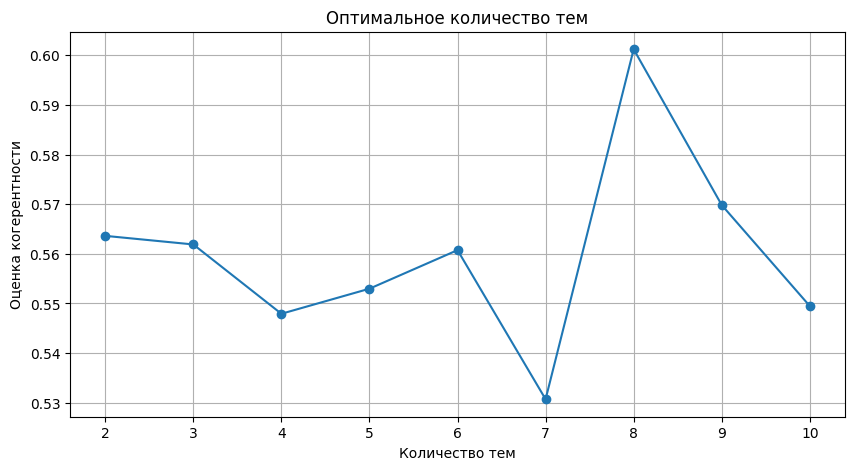

In [ ]:
import matplotlib.pyplot as plt

# Функция для вычисления когерентности
def compute_coherence_values(dictionary, corpus, texts, start=2, limit=50, step=3):
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        # Используем обычную LDA модель вместо Mallet для упрощения
        model = LdaModel(
            corpus=corpus,
            num_topics=num_topics,
            id2word=dictionary,
            passes=10,
            random_state=42,
            alpha='auto',
            eta='auto'
        )
        model_list.append(model)

        coherencemodel = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_values.append(coherencemodel.get_coherence())

        print(f"Тем: {num_topics}, Когерентность: {coherence_values[-1]:.3f}")

    return model_list, coherence_values

# Вычисление когерентности для разных количеств тем
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=data,
    start=2,
    limit=11,
    step=1
)

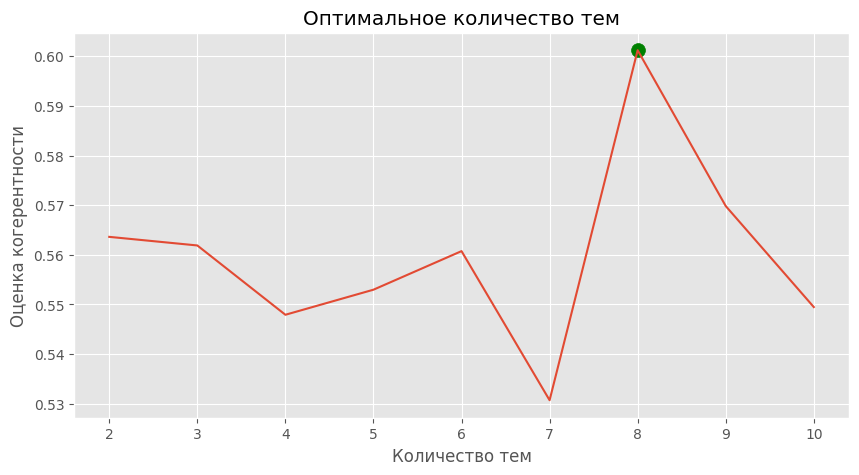

In [ ]:
# Визуализация результатов
x = range(2, 11, 1)
# Находим индекс максимального значения когерентности
max_coherence_idx = coherence_values.index(max(coherence_values))
max_x = x[max_coherence_idx]
max_y = coherence_values[max_coherence_idx]

# Создаем график
plt.figure(figsize=(10, 5))

# Основной график (все точки)
plt.plot(x, coherence_values, label='Когерентность')

# Выделяем максимальную точку красным
plt.scatter(max_x, max_y, color='green', s=100, label=f'Максимум ({max_x} тем, {max_y:.2f})')
plt.xlabel("Количество тем")
plt.ylabel("Оценка когерентности")
plt.title("Оптимальное количество тем")
plt.grid(True)
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
   print("Num Topics =", m, " is having Coherence Value of", round(cv, 4))

Num Topics = 2  is having Coherence Value of 0.5636
Num Topics = 3  is having Coherence Value of 0.5619
Num Topics = 4  is having Coherence Value of 0.5479
Num Topics = 5  is having Coherence Value of 0.553
Num Topics = 6  is having Coherence Value of 0.5608
Num Topics = 7  is having Coherence Value of 0.5307
Num Topics = 8  is having Coherence Value of 0.6012
Num Topics = 9  is having Coherence Value of 0.5698
Num Topics = 10  is having Coherence Value of 0.5495


In [ ]:
def compute_coherence_values(corpus, dictionary, k):
    lda_model = LdaModel(corpus=corpus, num_topics=k,
                                id2word=dictionary, passes=10,
                                per_word_topics=True, random_state=42)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=data,
                                         dictionary=dictionary, coherence='c_v')
    return coherence_model_lda.get_coherence()

import numpy as np
from tqdm.notebook import tqdm
import sys
from gensim.utils import ClippedCorpus

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)



# Validation sets
num_of_docs = len(corpus)
corpus_sets = [ClippedCorpus(corpus, int(num_of_docs*0.75)), corpus]
corpus_title = ['75% Corpus', '100% Corpus']

# results placeholder
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Coherence': []
                }

# tqdm progress bar
pbar = tqdm(total=(len(topics_range)*len(corpus_title)),
                 file=sys.stdout, colour='green')


for i in range(len(corpus_sets)):
    for k in topics_range:    # iterate through validation corpuses
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=corpus_sets[i],
                                              dictionary=dictionary,
                                              k=k)
                # Save the model results
                model_results['Validation_Set'].append(corpus_title[i])
                model_results['Topics'].append(k)
                model_results['Coherence'].append(cv)

                # update tqdm progress bar
                pbar.update(1)
                pbar.refresh()
pbar.close()


  0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame(model_results)
df

,Validation_Set,Topics,Coherence
0,75% Corpus,2,0.485249
1,75% Corpus,3,0.536149
2,75% Corpus,4,0.562532
3,75% Corpus,5,0.556507
4,75% Corpus,6,0.568703
5,75% Corpus,7,0.564753
6,75% Corpus,8,0.569630
7,75% Corpus,9,0.584370
8,75% Corpus,10,0.572485
9,100% Corpus,2,0.571573


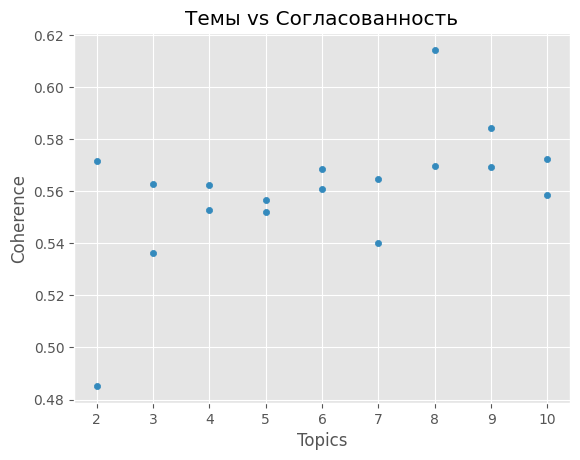

In [ ]:
df.plot.scatter(x='Topics', y='Coherence', title='Темы vs Согласованность');

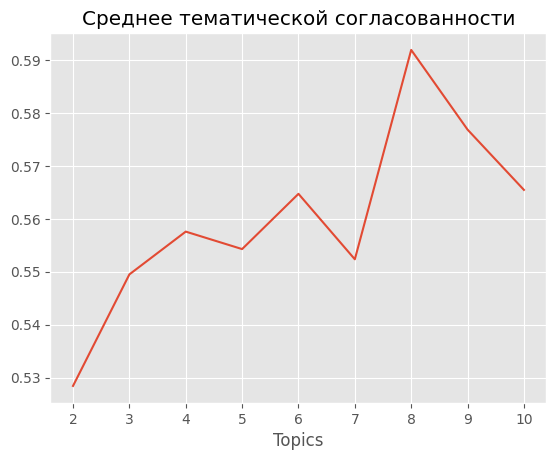

In [ ]:
df.groupby('Topics')['Coherence'].mean().plot(title='Среднее тематической согласованности')

In [ ]:
lda_model = LdaModel(corpus=corpus, num_topics=8,
                                id2word=dictionary, passes=10,
                                alpha='symmetric', eta=0.91,
                                per_word_topics=True, random_state=42)
coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=data,
                                         dictionary=dictionary, coherence='c_v')


In [ ]:
# Вычислить оценку согласованности при alpha = symmetric, eta = 0.91  и количестве тем = 8
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score:', coherence_lda)

Coherence Score: 0.6339036107303948


In [ ]:
lda_model = LdaModel(corpus=corpus, num_topics=9,
                                id2word=dictionary, passes=10,
                                alpha=0.61, eta=0.61,
                                per_word_topics=True, random_state=42)
coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=data,
                                         dictionary=dictionary, coherence='c_v')

In [ ]:
# Вычислить оценку согласованности при alpha, eta = 0.61  и количестве тем = 9
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score:', coherence_lda)

Coherence Score: 0.671175921660801


*По итогам экспериментов лучшее количество тем  = 9 при alpha, eta = 0.61*

In [ ]:
dictionary = Dictionary(data)
# Отфильтровать слова, которые встречаются менее чем в 20 документах или более чем в 40% документов.
dictionary.filter_extremes(no_below=20, no_above=0.4)
corpus = [dictionary.doc2bow(doc) for doc in data]
num_topics = 9
best_model = LdaModel(corpus=corpus, num_topics=num_topics,
                                id2word=dictionary, passes=15,
                                alpha=0.61, eta=0.61,
                                per_word_topics=True, random_state=42)

topics = [[(term, round(wt, 3))
               for term, wt in best_model.show_topic(n)]
                   for n in range(0, best_model.num_topics)]
topics_df = pd.DataFrame([[term for term, wt in topic]
                              for topic in topics],
                         index=['Тема '+str(t) for t in range(1, best_model.num_topics+1)]).T
topics_df

,Тема 1,Тема 2,Тема 3,Тема 4,Тема 5,Тема 6,Тема 7,Тема 8,Тема 9
0,желать,проект,помощь,школа,развитие,район,национальный,семья,карельский
1,поздравлять,конкурс,центр,район,предприятие,сутки,общественный,память,язык
2,здоровье,поддержка,медицинский,программа,производство,посёлок,политика,житель,культура
3,рождение,организация,больница,ремонт,правительство,ситуация,региональный,великий,вепсский
4,отмечать,заявка,специалист,здание,компания,коронавирус,организация,акция,национальный
5,карельский,фонд,республиканский,строительство,завод,находиться,министерство,победа,народный
6,успех,грант,оборудование,житель,регион,число,подробный,ребёнок,фестиваль
7,развитие,участие,врач,объект,проект,режим,представитель,петрозаводск,мероприятие
8,вклад,некоммерческий,средство,детский,поддержка,население,состояться,отечественный,подробный
9,наталья,НКО,хозяйство,посёлок,бизнес,петрозаводск,район,герой,состояться


На скольких токенах и документах будет проводится обучение:

In [ ]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 4794
Number of documents: 14835


In [ ]:
# Распечатать пропорцию темы в корпусе
topics = list(best_model.get_document_topics(corpus, minimum_probability=0))
for t in range(8):
    print(f"Topic {t} proportion: {100*sum([pair[t][1] for pair in topics])/len(topics):.1f}%")

Topic 0 proportion: 10.6%
Topic 1 proportion: 10.0%
Topic 2 proportion: 9.0%
Topic 3 proportion: 12.5%
Topic 4 proportion: 12.2%
Topic 5 proportion: 7.7%
Topic 6 proportion: 11.1%
Topic 7 proportion: 12.7%


In [ ]:
# для конкретного поста
script_idx = 15
print(data[script_idx])

# Возвращает распределение тем для статьи, отсортированное по вероятности.
topics = sorted(best_model.get_document_topics(corpus[script_idx]), key=lambda t: t[1])[::-1]
topics

['четверг', 'февраль', 'лоухский', 'район', 'провести', 'совещание', 'развитие', 'район', 'встретиться', 'житель', 'культура', 'адрес', 'лоухи', 'ул', 'комментарий', 'пост', 'задавать', 'онлайнтрансляция', 'районыонлайн']


[(7, 0.36621252),
 (5, 0.21907298),
 (6, 0.19028813),
 (3, 0.04960773),
 (8, 0.04933092),
 (4, 0.03702542),
 (1, 0.033828095),
 (0, 0.028007295),
 (2, 0.026626896)]

In [ ]:
best_model.show_topic(7, topn=10)  # 10 самых значимых слов темы

[('семья', 0.015509506),
 ('память', 0.012429674),
 ('житель', 0.01214075),
 ('великий', 0.0115562035),
 ('акция', 0.009690506),
 ('победа', 0.008809984),
 ('ребёнок', 0.008734873),
 ('петрозаводск', 0.00858205),
 ('отечественный', 0.0073850993),
 ('герой', 0.0072365818)]

In [ ]:
# для одного поста
post = "сюжет первый канал посвятить 80-летие официальный открытие беломорско-балтийский канал".split()
p = [post]
dictionary = corpora.Dictionary(p)
corpus = [dictionary.doc2bow(text) for text in  p]
topics = sorted(best_model.get_document_topics(corpus[0]), key=lambda t: t[1])[::-1]
topics

[(3, 0.28062907),
 (7, 0.24943402),
 (2, 0.12956834),
 (5, 0.10116219),
 (0, 0.055791527),
 (4, 0.054893788),
 (1, 0.04370743),
 (6, 0.042462215),
 (8, 0.042351425)]

In [ ]:
best_model.show_topic(3, topn=10)  # 10 самых значимых слов темы

[('школа', 0.0165922),
 ('район', 0.01586508),
 ('программа', 0.011234409),
 ('ремонт', 0.01081824),
 ('здание', 0.010319197),
 ('строительство', 0.0101943305),
 ('житель', 0.009507537),
 ('объект', 0.009183532),
 ('детский', 0.008048489),
 ('посёлок', 0.0076544927)]

In [ ]:
def get_top_topics(article_idx, min_topic_prob):

# Сортировать от наибольшей к наименьшей вероятности темы.
  topic_prob_pairs = sorted(best_model.get_document_topics(corpus[article_idx],
                                                          minimum_probability=min_topic_prob), key=lambda tup: tup[1])[::-1]

  word_prob_pairs = [best_model.show_topic(pair[0]) for pair in topic_prob_pairs]
  topic_words = [[pair[0] for pair in collection] for collection in word_prob_pairs]

  data = {
      'Major Topics': topic_prob_pairs,
      'Topic Words': topic_words
  }

  return pd.DataFrame(data)
pd.set_option('max_colwidth', 600)
min_topic_prob = 0.25

article_idx = 1
print(data[article_idx])
get_top_topics(article_idx, min_topic_prob)

['апрель', 'возобновимый', 'реставрация', 'горный', 'начальник', 'здание', 'петрозаводск', 'энгельс', 'живой', 'участник', 'история', 'свидетель', 'эпоха', 'построить', 'век', 'шотландский', 'инженер', 'чарльз', 'гаскойный', 'приехать', 'карелия', 'приглашение', 'екатерина', 'развитие', 'олонецкий', 'горный', 'завод', 'реставрация', 'этап', 'бывать', 'исторический', 'здание', 'обнаружиться', 'уникальный', 'строительный', 'приём', 'элемент', 'выявиться', 'необходимость', 'дополнительный', 'потребовать', 'разработка', 'ПСД', 'поиск', 'средство', 'ставить', 'задача', 'привести', 'порядок', 'внешний', 'контур', 'кровля', 'уникальный', 'архитектурный', 'комплекс', 'предусмотреть', 'бюджет', 'республика', 'порядок', 'млн', 'рубль', 'цель', 'далее', 'федеральный', 'центр', 'решать', 'проведение', 'внутренний', 'устройство', 'экспозиция', 'национальный', 'музей', 'нашакарелия']


,Major Topics,Topic Words
0,"(3, 0.3932583)","[школа, район, программа, ремонт, здание, строительство, житель, объект, детский, посёлок]"


## Оценка человеком
Поскольку количественные показатели не полностью коррелируют с качеством, человеческое суждение по-прежнему играет большую роль в оценке тематической модели.

Мы можем попросить кого-нибудь посмотреть на тематические слова, чтобы увидеть, насколько они интерпретируемы.

Существуют также субъективные тесты, такие как вторжение слов и вторжение тем.

Внедрение слов — это взятие слов, которые принадлежат теме, введение слова из другой темы в коллекцию и проверка того, может ли человек легко определить слово-нарушитель. Чем легче обнаружить слово-нарушитель, тем лучше сформирована тема. Например, какое слово не принадлежит этой теме?

{apple, lemon, tomato, horse, grape}

Мы также можем визуализировать их с помощью облаков слов.

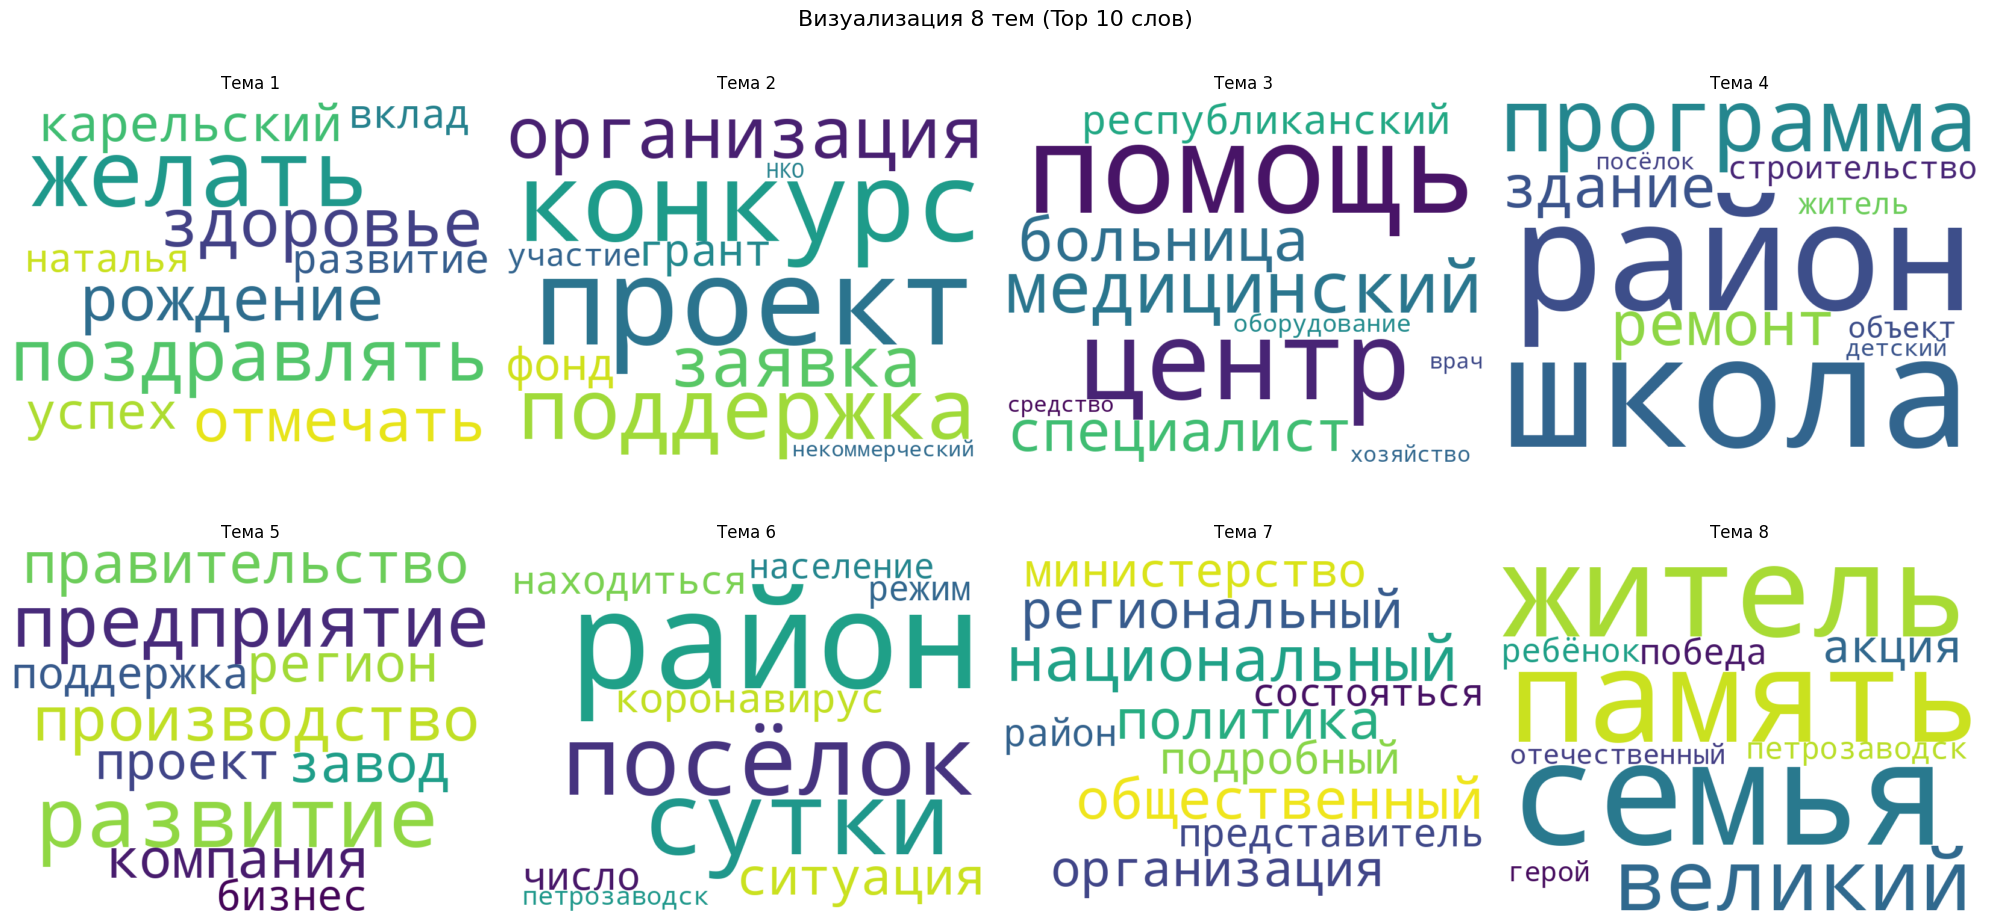

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def visualize_topics_8(model, max_words=15):
    """
    Визуализирует все 8 тем модели LDA в виде облаков слов

    Параметры:
    model - обученная LDA модель
    max_words - максимальное количество слов для отображения в каждом облаке
    """
    # Настройки облака слов
    wordcloud = WordCloud(
        background_color='white',
        max_words=max_words,
        width=800,
        height=600,
        prefer_horizontal=1.0,
        colormap='viridis',
        contour_width=1
    )

    # Создаем сетку 2x4 для 8 тем
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle('Визуализация 8 тем (Top {} слов)'.format(max_words), fontsize=16)
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    for topic_num in range(8):
        ax = axes[topic_num//4, topic_num%4]  # Распределение по сетке 2x4

        # Получаем слова и их веса для темы
        topic_words = dict(model.show_topic(topic_num, topn=max_words))

        # Генерируем и отображаем облако слов
        wordcloud.generate_from_frequencies(topic_words)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title('Тема {}'.format(topic_num+1), pad=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Пример использования
visualize_topics_8(best_model, max_words=10)

# Интерактивная визуализация тематических моделей


*   Распределение тем в документах

*   Ключевые слова каждой темы

*   Сходство между темами (через расстояния на 2D-плоскости)




*Главный график (Карта расстояний между темами)*

Каждый пузырь — одна тема

Размер пузыря — распространённость темы в корпусе

Расстояние между пузырями — семантическая близость тем

Оси — линейные комбинации слов (PC1/PC2), уменьшенные до 2D через PCA


*Top-30 слов для выбранной темы*

Показывает наиболее релевантные слова темы


Relevance (λ=0.6 по умолчанию) — баланс между:

Внутри-тематической частотой (term frequency within topic)

Уникальностью для темы (exclusivity to topic)

Чем больше λ, тем более частотные слова отображаются, чем меньше, тем более уникальные.




In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

vis = gensimvis.prepare(best_model, corpus, dictionary)

pyLDAvis.display(vis)

Визуализация распределения вероятностей топ-100 слов для каждой темы LDA-модели в виде кривых зависимостей весов слов от их ранга. График позволяет сравнить темы по крутизне спада вероятностей и степени концентрации вокруг ключевых слов.

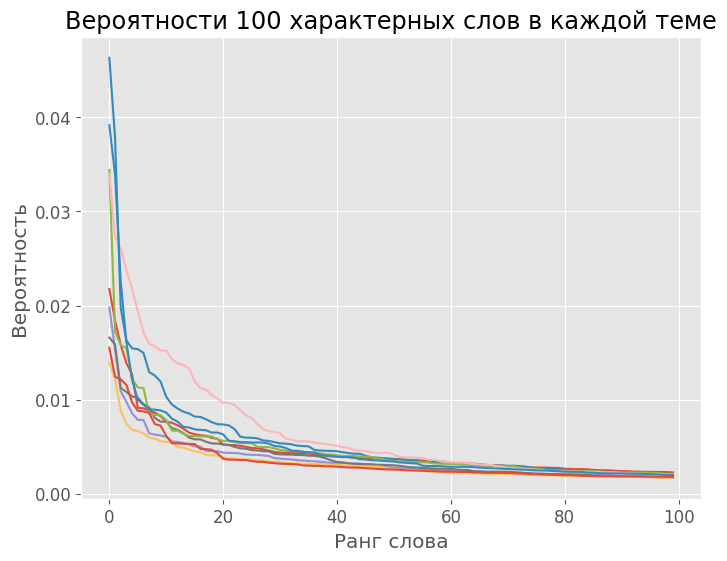

In [ ]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

# 100 лучших слов по весу в каждой теме
top_n_words = 100
topics = best_model.show_topics(
    num_topics = num_topics, num_words = top_n_words, formatted = False)

for _, infos in topics:
    probs = [prob for _, prob in infos]
    plt.plot(range(top_n_words), probs)

plt.xlabel('Ранг слова')
plt.ylabel('Вероятность')
plt.title('Вероятности 100 характерных слов в каждой теме')
plt.show()

In [ ]:
# Создаем DataFrame для хранения результатов
sent_topics_df = pd.DataFrame(columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text'])

# Обрабатываем каждый документ в корпусе
for i, doc in enumerate(corpus):  # Используем corpus вместо lda_model[corpus]
    # Получаем распределение тем для документа
    doc_topics = best_model.get_document_topics(doc)  # Это правильный способ получить темы документа

    # Сортируем темы по убыванию вероятности
    doc_topics_sorted = sorted(doc_topics, key=lambda x: x[1], reverse=True)

    if doc_topics_sorted:  # Проверяем, что есть темы
        # Берем доминирующую тему
        dominant_topic_num, dominant_topic_prob = doc_topics_sorted[0]

        # Получаем ключевые слова темы
        topic_keywords = ", ".join([word for word, prob in best_model.show_topic(dominant_topic_num)])

        # Добавляем информацию в DataFrame
        sent_topics_df.loc[i] = [
            int(dominant_topic_num),
            round(dominant_topic_prob, 4),
            topic_keywords,
            " ".join(data[i])  # Объединяем токены в текст
        ]


In [ ]:
sent_topics_df.head(15)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,3,0.4843,"школа, район, программа, ремонт, здание, строительство, житель, объект, детский, посёлок",добрый быстро расти лобановский мост основный металлоконструкция установить смонтировать основной блок поперечный балка завершаться сварочный несмотря снег низкий температура специалист балтмостстрой ударный темп нашакарелия
1,3,0.4895,"школа, район, программа, ремонт, здание, строительство, житель, объект, детский, посёлок",апрель возобновимый реставрация горный начальник здание петрозаводск энгельс живой участник история свидетель эпоха построить век шотландский инженер чарльз гаскойный приехать карелия приглашение екатерина развитие олонецкий горный завод реставрация этап бывать исторический здание обнаружиться уникальный строительный приём элемент выявиться необходимость дополнительный потребовать разработка ПСД поиск средство ставить задача привести порядок внешний контур кровля уникальный архитектурный комплекс предусмотреть бюджет республика порядок млн рубль цель далее федеральный центр решать проведен...
2,7,0.4477,"семья, память, житель, великий, акция, победа, ребёнок, петрозаводск, отечественный, герой",больший удовольствие старт чемпионат орган безопасность федеральный округ фок динамо состояться соревнование течение неделя команда участник состязаться лыжный гонка плавание стрельба двоеборье петрозаводск принимать спартакиада посвятить победа великий отечественный символичный общество динамо великий отечественный активно включиться подготовка население оборона спортивный секция превратиться проведение тренировочный сбор член общество помогать готовить военный отряд июнь спортобъект динамо передать военный обучение солдат ребята стража безопасность желать участник удача пусть победить си...
3,2,0.4231,"помощь, центр, медицинский, больница, специалист, республиканский, оборудование, врач, средство, хозяйство",история сумка аксессуар ручной красота уникальность наверняка многие оценить история семья увлечь творчество кондопожанка шенина мама четверо ребёнок открыть семейный мастерская старинный деревня многий знакомый совдозеро корень семья история деревня сохраняться продолжаться творчество поколение ксения мама дочь валерий серафим любовь родный край передавать творчество использовать создание сумка рюкзак изображение карельский ягода цвет растение открыть мастерица помочь благодаря соцконтракт ксения приобрести оборудование расходный материал начинающий предприниматель финансовый поддержка от...
4,3,0.5753,"школа, район, программа, ремонт, здание, строительство, житель, объект, детский, посёлок",поделиться итог рабочий поездка север карелия неделя кемь калевала лоухи беломорск ключевой безусловно встреча земляк актуальный повестка район оставаться медицина ЖКХ ремонт образовательный учреждение расселение аварийный жильё задать встреча отработать коллега доложить поручение число пример ремонт городской стадион кемь возможность продление автобусный маршрут костомукша боровой юшкозеро райцентр организация хирургия чупа решение кадровый проблема медик беломорск расселение аварийный жильё задача номер район сформировать общественный комиссия определять первоочерёдность расселение авари...
5,3,0.6300,"школа, район, программа, ремонт, здание, строительство, житель, объект, детский, посёлок",беломорск завершать серия встреча житель северный район живой диалог обсудить развитие округ коротко медицина установить пушной модульный ФАП капитально отремонтировать фап посёлок колежма машезеро решать кадровый проблема договор ЦРБ обучаться целевиковый жильё утверждение федеральный программа предстоять расселить округ квартира проживать тыс сложный задача отметить единственный район строительство переселение готовый проект пройти экспертиза положительный заключение квартира строить строительный образование капитально отремонтировать школа беломорск приступить ремонт школа план ставить ...
6,7,0.6957,"семья, память, житель, великий, акция, победа, ребёнок, петрозаводск, отечест

In [ ]:
# Получаем статистику по темам
topic_counts = sent_topics_df['Dominant_Topic'].value_counts().sort_index()  # Сортировка по номерам тем
topic_contribution = round(topic_counts / topic_counts.sum(), 4) * 100  # Проценты с округлением

# Убедимся, что все 8 тем присутствуют (даже если для некоторых 0 документов)
all_topics = range(8)  # Для 8 тем (0-7)
topic_counts = topic_counts.reindex(all_topics, fill_value=0)
topic_contribution = topic_contribution.reindex(all_topics, fill_value=0)

# Получаем уникальные пары "Тема-Ключевые слова"
topic_num_keywords = (
    sent_topics_df[['Dominant_Topic', 'Topic_Keywords']]
    .drop_duplicates()
    .set_index('Dominant_Topic')
    .reindex(all_topics)  # Добавляем все темы, даже если они не встретились
)

# Собираем финальную таблицу
df_dominant_topics = pd.concat([
    topic_num_keywords,
    topic_counts.rename('Num_Documents'),
    topic_contribution.rename('Perc_Documents')
], axis=1).reset_index()

# Переименовываем колонки
df_dominant_topics.columns = [
    'Topic-ID',
    'Keywords',
    'Documents Count',
    'Documents %'
]

# Заполняем пропущенные ключевые слова (если тема не встретилась)
df_dominant_topics['Keywords'] = df_dominant_topics['Keywords'].fillna(
    df_dominant_topics['Topic-ID'].apply(
        lambda x: ", ".join([w for w, _ in best_model.show_topic(x)])
    )
)

# Сортируем по номеру темы (по возрастанию)
df_dominant_topics = df_dominant_topics.sort_values('Topic-ID')

# Форматируем проценты
df_dominant_topics['Documents %'] = df_dominant_topics['Documents %'].apply(lambda x: f"{x:.1f}%")

# Выводим все 8 тем, отсортированные по ID
print(f"\nРаспределение {len(df_dominant_topics)} тем (отсортировано по номеру темы):")
display(df_dominant_topics)
# отсоритировать и гистограмма


Распределение 8 тем (отсортировано по номеру темы):


,Topic-ID,Keywords,Documents Count,Documents %
0,0,"желать, поздравлять, здоровье, рождение, отмечать, карельский, успех, развитие, вклад, наталья",1660,11.2%
1,1,"проект, конкурс, поддержка, организация, заявка, фонд, грант, участие, некоммерческий, НКО",1215,8.2%
2,2,"помощь, центр, медицинский, больница, специалист, республиканский, оборудование, врач, средство, хозяйство",1185,8.0%
3,3,"школа, район, программа, ремонт, здание, строительство, житель, объект, детский, посёлок",1983,13.4%
4,4,"развитие, предприятие, производство, правительство, компания, завод, регион, проект, поддержка, бизнес",1891,12.8%
5,5,"район, сутки, посёлок, ситуация, коронавирус, находиться, число, режим, население, петрозаводск",814,5.5%
6,6,"национальный, общественный, политика, региональный, организация, министерство, подробный, представитель, состояться, район",1386,9.3%
7,7,"семья, память, житель, великий, акция, победа, ребёнок, петрозаводск, отечественный, герой",2184,14.7%


#Запросы на схожесть



Предположим, что пользователь ввел запрос «общественный региональный проект» . Мы хотели бы отсортировать наши корпусные документы в порядке убывания релевантности этому запросу. В отличие от современных поисковых систем, здесь мы концентрируемся только на одном аспекте возможных сходств — на очевидной семантической связанности их текстов (слов). Никаких гиперссылок, никаких случайных статических рангов, только семантическое расширение по булевому совпадению ключевых слов:

In [ ]:
from gensim import models
from gensim import similarities
import pandas as pd

# Создаем и обучаем LSI модель
lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=8)

# Преобразуем запрос в LSI пространство
doc = "общественный региональный проект"
vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lsi = lsi[vec_bow]

# Создаем индекс схожести
index = similarities.MatrixSimilarity(lsi[corpus])

# Получаем результаты схожести
sims = index[vec_lsi]
sorted_sims = sorted(enumerate(sims), key=lambda item: -item[1])

# Создаем красивый DataFrame для вывода
results = []
for doc_position, doc_score in sorted_sims:
    results.append({
        'ID документа': doc_position,
        'Оценка схожести': f"{doc_score:.4f}",
        'Текст документа': ' '.join(data[doc_position][:300]) + '...'  # Первые 300 слов
    })

# Преобразуем в DataFrame с красивым форматированием
df_results = pd.DataFrame(results)


In [ ]:
from gensim import models
from gensim import similarities
import pandas as pd

# Создаем и обучаем LSI модель
lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=8)

# Преобразуем запрос в LSI пространство
doc = "короновирус больница"
vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lsi = lsi[vec_bow]

# Создаем индекс схожести
index = similarities.MatrixSimilarity(lsi[corpus])

# Получаем результаты схожести
sims = index[vec_lsi]
sorted_sims = sorted(enumerate(sims), key=lambda item: -item[1])

# Создаем красивый DataFrame для вывода
results = []
for doc_position, doc_score in sorted_sims:
    results.append({
        'ID документа': doc_position,
        'Оценка схожести': f"{doc_score:.4f}",
        'Текст документа': ' '.join(data[doc_position][:300]) + '...'  # Первые 300 слов
    })

# Преобразуем в DataFrame с красивым форматированием
df_results = pd.DataFrame(results)
df_results.head(5)

/usr/local/lib/python3.11/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning: `scipy.sparse.sparsetools.csc_matvecs` is deprecated along with the `scipy.sparse.sparsetools` namespace. `scipy.sparse.sparsetools.csc_matvecs` will be removed in SciPy 1.14.0, and the `scipy.sparse.sparsetools` namespace will be removed in SciPy 2.0.0.
  sparsetools.csc_matvecs(


,ID документа,Оценка схожести,Текст документа
0,2014,0.9726,оборудование помощь сортавальский хирург операционный блок сортавальский больница установить современный оборудование передвижной рентгеновский аппарат манёвренный гибкий функция быстрый подключение обеспечивать максимально качественный визуализация операция канун сортавальский хирург проэкзаменовать аппарат пациент открытый репозиция металлоостеосинтез левый плечевой кость установка углостабильный пластина операция специалист снимок позволять правильно установить металлоконструкция сократить сложный операция...
1,7629,0.9605,вновь предлагать прекратить распространять откровенный медицинский учреждение населить пункт ладва шелтозеро деревянный переходить юрисдикция республиканский больница связь ликвидация сохраняться учёт возможность РБ дополнительно населить пункт педасельга учёт анализ маршрутизация создаваться пункт неотложный скорый круглосуточный помощь размещение пункт выделить помещение предусмотреть скорый...
2,8415,0.9557,вчера встретиться турслёт коллектив медвежьегорский ЦРБ проблема обновление технический база больница республика прорабатывать выделение средство медоборудование больница необходимо точный понимание больница аппарат необходимый...
3,5043,0.9545,спасибоврач неделя близкий родный врач фельдшер скорый помощь персонал больница поликлиника амбулатория фап готовый прийти помощь зачастую жертвовать личный здоровье медицинский работник ежедневный труд...
4,7736,0.9528,больница карелия начало поступать медицинский оборудование закупить средство резервный фонд президент кондопожский ЦРБ современный эндоскопический техника ангиографический установка аппарат искусственный кровообращение цифровой рентгендиагностический видеоэндоскопический комплекс республиканский больница баранов аппарат искусственный вентиляция лёгкий петрозаводский больница скорый медицинский помощь эндовидеохирургический стойка республиканский онкологический диспансер цифровой рентгендиагностический комплекс детский республиканский больница...
